In [17]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from model.VAE import *
import torch.optim as optim

# import argparse

# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 VAE Training')
# parser.add_argument('--batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--test-batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for testing (default: 128)')
# parser.add_argument('--x-dim', type=int, default=784)
# parser.add_argument('--hidden-dim', type=int, default=400)
# parser.add_argument('--latent-dim', type=int, default=200)
# parser.add_argument('--epochs', type=int, default=30)
# args = parser.parse_args()

torch.manual_seed(1)
lr = 1e-3
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 400
test_batch_size = 200
x_dim = 784
latent_dim = 200
epochs = 50
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform_test)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, **kwargs)


def loss_function(x, label, x_hat, mean, log_var, logit):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    vae_loss = reproduction_loss + KLD
    c_loss = nn.CrossEntropyLoss()(logit, label)
    beta = 0.5
    loss = vae_loss * beta + c_loss * (1 - beta) 
    return loss

def vae_loss(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    vae_loss = reproduction_loss + KLD
    return vae_loss

def train(vae_model, c_model, data_loader, vae_optimizer, c_optimizer, epoch_num):
    vae_model.train()
    c_model.train()
    loss_sum = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        #data = data.view(batch_size, x_dim)
        data, target = data.to(device), target.to(device)
        vae_optimizer.zero_grad()
        c_optimizer.zero_grad()
        x_hat, mean, log_v = vae_model(data)
        x_cat = torch.cat((mean, log_v),1)
        logit = c_model(x_cat.detach())
        loss = loss_function(data, target, x_hat, mean, log_v, logit)
        loss_sum += loss
        loss.backward()
        # if epoch_num % 2 == 1:
        c_optimizer.step()
        vae_optimizer.step()
    return loss_sum


vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=lr)
c_model = classifier(input_dim=256*2).to(device)
c_optimizer = optim.Adam(c_model.parameters(), lr=lr)
print(len(train_loader.dataset))
for epoch in range(1, epochs+1):
    loss = train(vae_model,c_model, train_loader, vae_optimizer, c_optimizer, epoch)
    print('Epoch {}: Average loss: {:.6f}'.format(epoch, loss/len(train_loader.dataset)))



60000


In [3]:
import matplotlib.pyplot as plt
def show_image(x, idx):
    x = x.view(test_batch_size, 28, 28)
    fig = plt.figure()
    plt.imshow(x[idx].detach().cpu().numpy())

In [4]:
def model_pred(x, vae_model, c_model):
    x_hat, mean, log_v = vae_model(x)
    x_cat = torch.cat((mean, log_v), 1)
    logit = c_model(x_cat)
    return logit, mean, log_v

def testtime_update(vae_model, x_adv, learning_rate=0.1, num = 20):
    x_hat_adv, mean, log_v= vae_model(x_adv)
    x_adv = x_adv.detach()
    for _ in range(num):
        loss = vae_loss(x_adv, x_hat_adv, mean, log_v)
        mean.retain_grad()
        log_v.retain_grad()
        loss.backward(retain_graph=True)
        with torch.no_grad():
            mean.data -= learning_rate * mean.grad.data
            log_v.data -= learning_rate * log_v.grad.data
        mean.grad.data.zero_()
        log_v.grad.data.zero_()
        x_hat_adv = vae_model.decoder(vae_model.reparameterize(mean, log_v))
    return mean, log_v

In [5]:
def test(vae_model, c_model):
    err_num = 0
    err_adv = 0
    c_model.eval()
    vae_model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        logit, _, _ = model_pred(data, vae_model, c_model)
        err_num += (logit.data.max(1)[1] != target.data).float().sum()
        x_adv = pgd(vae_model, c_model, data, target, 40, 0.3, 0.01)
        m_adv, log_adv = testtime_update(vae_model, x_adv)
        x_cat_adv = torch.cat((m_adv, log_adv), 1)
        logit_adv = c_model(x_cat_adv)
        err_adv += (logit_adv.data.max(1)[1] != target.data).float().sum()
    print(len(test_loader.dataset))
    print(err_num)
    print(err_adv)

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from torch.autograd import Variable
def pgd(vae_model, c_model, X, label, num_steps, epsilon, step_size):
    X_pgd = Variable(X.data, requires_grad=True)
    for _ in range(num_steps):
        opt = optim.SGD([X_pgd], lr=1e-3)
        opt.zero_grad()
        with torch.enable_grad():
            _, mean, log_v = vae_model(X_pgd)
            x_cat = torch.cat((mean, log_v), 1)
            logit = c_model(x_cat)
            loss = nn.CrossEntropyLoss()(logit, label)
        loss.backward()
        eta = step_size * X_pgd.grad.data.sign()
        X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
        eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
        X_pgd = Variable(X.data + eta, requires_grad=True)
        X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
    return X_pgd

In [7]:
test(vae_model, c_model)

10000
tensor(109., device='cuda:0')
tensor(6944., device='cuda:0')


In [8]:
for data, target in test_loader:
    x, y = data.to(device), target.to(device)
    x_adv = pgd(vae_model, c_model, x, y, 40, 0.3, 0.01)
    break
x_hat, _,_ = vae_model(x)
x_hat_adv, mean, log_v = vae_model(x_adv)
x_cat = torch.cat((mean, log_v), 1)
logit = c_model(x_cat)
print(logit.max(1)[1])

tensor([3, 1, 4, 5, 9, 7, 9, 4, 8, 4, 5, 3, 4, 7, 3, 3, 7, 5, 8, 9, 7, 5, 4, 2,
        9, 7, 9, 9, 5, 4, 5, 9, 5, 6, 2, 5, 2, 7, 5, 4, 4, 2, 9, 4, 5, 8, 9, 4,
        9, 3, 3, 5, 9, 3, 8, 5, 7, 7, 4, 7, 5, 2, 7, 2, 9, 9, 9, 9, 5, 6, 5, 6,
        5, 7, 4, 9, 5, 1, 4, 5, 9, 5, 4, 9, 5, 8, 9, 7, 2, 7, 5, 5, 4, 9, 8, 9,
        9, 5, 5, 4, 5, 6, 2, 3, 5, 7, 5, 6, 4, 8, 2, 1, 5, 4, 3, 9, 9, 3, 4, 7,
        9, 6, 5, 9, 4, 4, 9, 8, 3, 9, 9, 5, 3, 2, 3, 4, 5, 4, 5, 9, 3, 9, 2, 3,
        9, 4, 9, 4, 5, 5, 4, 8, 8, 3, 4, 9, 4, 7, 2, 9, 8, 9, 2, 9, 4, 3, 5, 3,
        8, 9, 9, 2, 3, 5, 8, 9, 4, 9, 4, 2, 4, 2, 3, 2, 3, 4, 3, 3, 5, 3, 7, 9,
        2, 8, 5, 8, 3, 4, 9, 3], device='cuda:0')


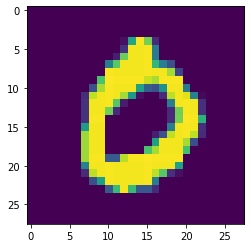

In [13]:
idex = 3
show_image(x, idx=idex)

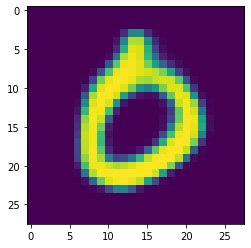

In [14]:
show_image(x_hat, idx=idex)

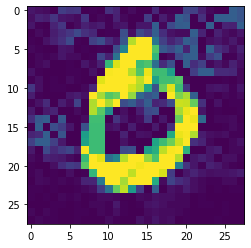

In [15]:
show_image(x_adv, idx=idex)

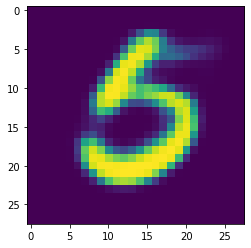

In [16]:
show_image(x_hat_adv, idx=idex)